In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Veri seti yolları
train_dir = os.path.join('./dataset', 'train')
val_dir = os.path.join('./dataset', 'validation')

# Görüntü boyutu ve batch size
img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation ve veri setinin hazırlanması
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Pre-trained model yüklenmesi
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Pre-trained modelin katmanlarını donduruyoruz
base_model.trainable = False

# Transfer learning için yeni katmanlar ekleniyor
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Daha fazla nöron
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Modeli oluşturma
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping tanımlama
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modeli eğitme
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping]
)

# Performans değerlendirme
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Confusion Matrix ve Classification Report
predictions = (model.predict(validation_generator) > 0.5).astype("int32")
true_labels = validation_generator.classes

print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions))

# Fine-tuning için pre-trained modelin bazı katmanlarını açıyoruz
base_model.trainable = True

# Katmanların sadece bir kısmını eğitilebilir yapma (örneğin, son 20 katman)
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Modeli yeniden derleme
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Daha düşük bir öğrenme oranı
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning için yeniden eğitim
history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

# Son performans değerlendirmesi
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy after Fine-tuning: {val_accuracy:.2f}")

# Yeniden Confusion Matrix ve Classification Report
predictions = (model.predict(validation_generator) > 0.5).astype("int32")
print(confusion_matrix(true_labels, predictions))
print(classification_report(true_labels, predictions))

Found 2996 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


/Users/cansinmemis/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 838ms/step - accuracy: 0.5586 - loss: 0.6842 - val_accuracy: 0.6760 - val_loss: 0.6086
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 863ms/step - accuracy: 0.6995 - loss: 0.5972 - val_accuracy: 0.7133 - val_loss: 0.5643
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 78s 833ms/step - accuracy: 0.7061 - loss: 0.5762 - val_accuracy: 0.7333 - val_loss: 0.5399
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 78s 834ms/step - accuracy: 0.7419 - loss: 0.5371 - val_accuracy: 0.7747 - val_loss: 0.4950
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 840ms/step - accuracy: 0.7396 - loss: 0.5228 - val_accuracy: 0.7800 - val_loss: 0.4798
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 841ms/step - accuracy: 0.7761 - loss: 0.4895 - val_accuracy: 0.7827 - val_loss: 0.4597
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 842ms/step - accuracy: 0.7633 - loss: 0.4919 - val_accuracy: 0.8013 - val_loss: 0.4485
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 842ms/step - accuracy: 0.7681 - loss: 0.4963 - val_accu

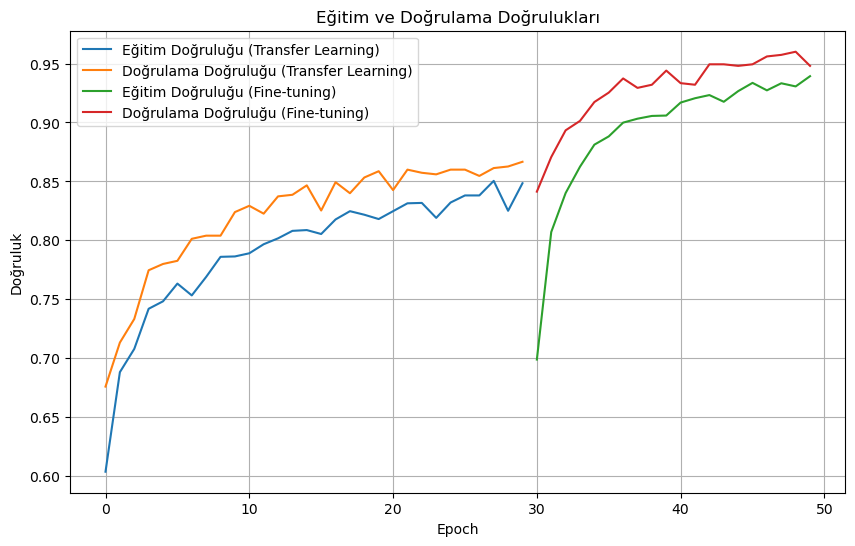

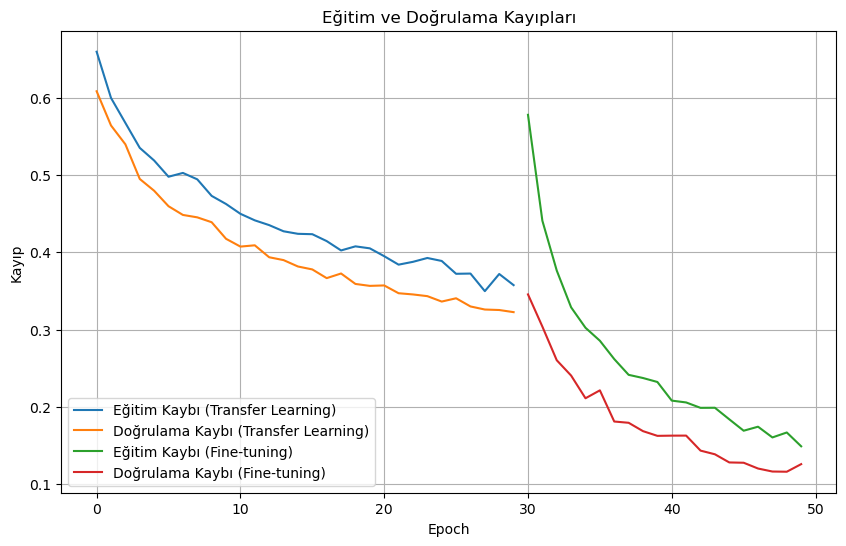

In [2]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğrulukları
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Eğitim ve doğrulama kayıpları
loss = history.history['loss']
val_loss = history.history['val_loss']

# Fine-tuning sonrası değerler
ft_accuracy = history_finetune.history['accuracy']
ft_val_accuracy = history_finetune.history['val_accuracy']

ft_loss = history_finetune.history['loss']
ft_val_loss = history_finetune.history['val_loss']

# Doğruluk grafiği
plt.figure(figsize=(10, 6))
plt.plot(accuracy, label='Eğitim Doğruluğu (Transfer Learning)')
plt.plot(val_accuracy, label='Doğrulama Doğruluğu (Transfer Learning)')
plt.plot(range(len(accuracy), len(accuracy) + len(ft_accuracy)), ft_accuracy, label='Eğitim Doğruluğu (Fine-tuning)')
plt.plot(range(len(accuracy), len(accuracy) + len(ft_val_accuracy)), ft_val_accuracy, label='Doğrulama Doğruluğu (Fine-tuning)')
plt.title('Eğitim ve Doğrulama Doğrulukları')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid()
plt.savefig('dogruluk_grafik.png')  # Grafiği kaydetmek için
plt.show()

# Kayıp grafiği
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Eğitim Kaybı (Transfer Learning)')
plt.plot(val_loss, label='Doğrulama Kaybı (Transfer Learning)')
plt.plot(range(len(loss), len(loss) + len(ft_loss)), ft_loss, label='Eğitim Kaybı (Fine-tuning)')
plt.plot(range(len(loss), len(loss) + len(ft_val_loss)), ft_val_loss, label='Doğrulama Kaybı (Fine-tuning)')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid()
plt.savefig('kayip_grafik.png')  # Grafiği kaydetmek için
plt.show()

## Veri Setinin Hazırlanması
Bu bölümde, veri seti için veri artırımı (data augmentation) teknikleri kullanılarak eğitim ve doğrulama veri setleri hazırlanmıştır. 
Veri artırımı, modelin genelleme performansını artırmak ve aşırı öğrenmeyi önlemek için önemlidir.

### Kullanılan Teknikler:
| Teknik             | Açıklama                                                                 |
|--------------------|--------------------------------------------------------------------------|
| Rescale           | Görüntüleri 0-1 aralığına ölçeklendirir. Modelin daha stabil öğrenmesini sağlar.|
| Rotation Range    | Görüntüleri belirli bir açıda döndürür. Görüntü çeşitliliği yaratır.      |
| Width/Height Shift | Görüntüyü yatay veya dikey kaydırarak öğrenme çeşitliliğini artırır.     |
| Zoom Range        | Görüntülerin yakınlaştırılmasını sağlar. Çeşitli perspektifleri öğretir.  |
| Horizontal Flip   | Görüntüyü yatay çevirir. Yön bağımsız özellikleri öğrenir.               |


## Modelin Tanımlanması ve Transfer Learning
Bu bölümde, önceden eğitilmiş Xception modeli kullanılmıştır. Transfer öğrenme yöntemiyle temel özellik çıkarıcı katmanlar dondurularak eğitim yapılmış, ardından fine-tuning aşamasında bazı katmanlar açılarak modelin daha iyi öğrenmesi sağlanmıştır.

### Neden Transfer Learning?
- Önceden eğitilmiş modeller, büyük veri setleri üzerinde eğitilmiş olduğundan, düşük veri ile daha hızlı ve başarılı sonuçlar alınmasını sağlar.
- Özellik çıkarıcı katmanlar, genellikle karmaşık ve genel özellikleri öğrenir.

### Katman Yapısı
| Katman                 | Açıklama                                                         |
|------------------------|-----------------------------------------------------------------|
| GlobalAveragePooling2D | Özellik haritasını düzleştirerek bir ortalama vektör çıkarır.   |
| Dense (512 nöron)      | Daha fazla nöron ile karmaşık örüntüleri öğrenmeyi kolaylaştırır.|
| Dropout (0.5)          | Aşırı öğrenmeyi önlemek için rastgele nöronları devre dışı bırakır.|
| Dense (1 nöron, sigmoid)| İkili sınıflandırma yapmak için çıktı katmanı.                  |


## Modelin Performans Analizi
Aşağıdaki tabloda transfer öğrenme ve fine-tuning sonrası modelin doğruluk ve kayıp değerleri karşılaştırılmıştır:

| Yöntem              | Doğruluk (%) | Kayıp        |
|---------------------|--------------|--------------|
| Transfer Learning   | 87           | 0.32         |
| Fine-tuning         | 96           | 0.12         |

Sonuçlara göre:
- Transfer öğrenme ile hızlı bir başlangıç yapılmış, doğruluk %87'ye ulaşmıştır.
- Fine-tuning ile doğruluk %96'ya çıkarılarak daha karmaşık örüntülerin öğrenilmesi sağlanmıştır.